# Using CAMEL to Do Graph RAG with Mistral Models

You can also check this cookbook in colab [here](https://colab.research.google.com/drive/1uZKQSuu0qW6ukkuSv9TukLB9bVaS1H0U?usp=sharing)

This cookbook walks you through the process of performing graph-based Retrieval-Augmented Generation (RAG) using **CAMEL**, powered by the advanced **Mistral** models. Specifically, we'll utilize the **Mistral Large 2** model to extract and structure knowledge from a given content source, and store this information in a **Neo4j** graph database. Subsequently, we can leverage a hybrid approach, combining vector retrieval and knowledge graph retrieval, to query and explore the stored knowledge.

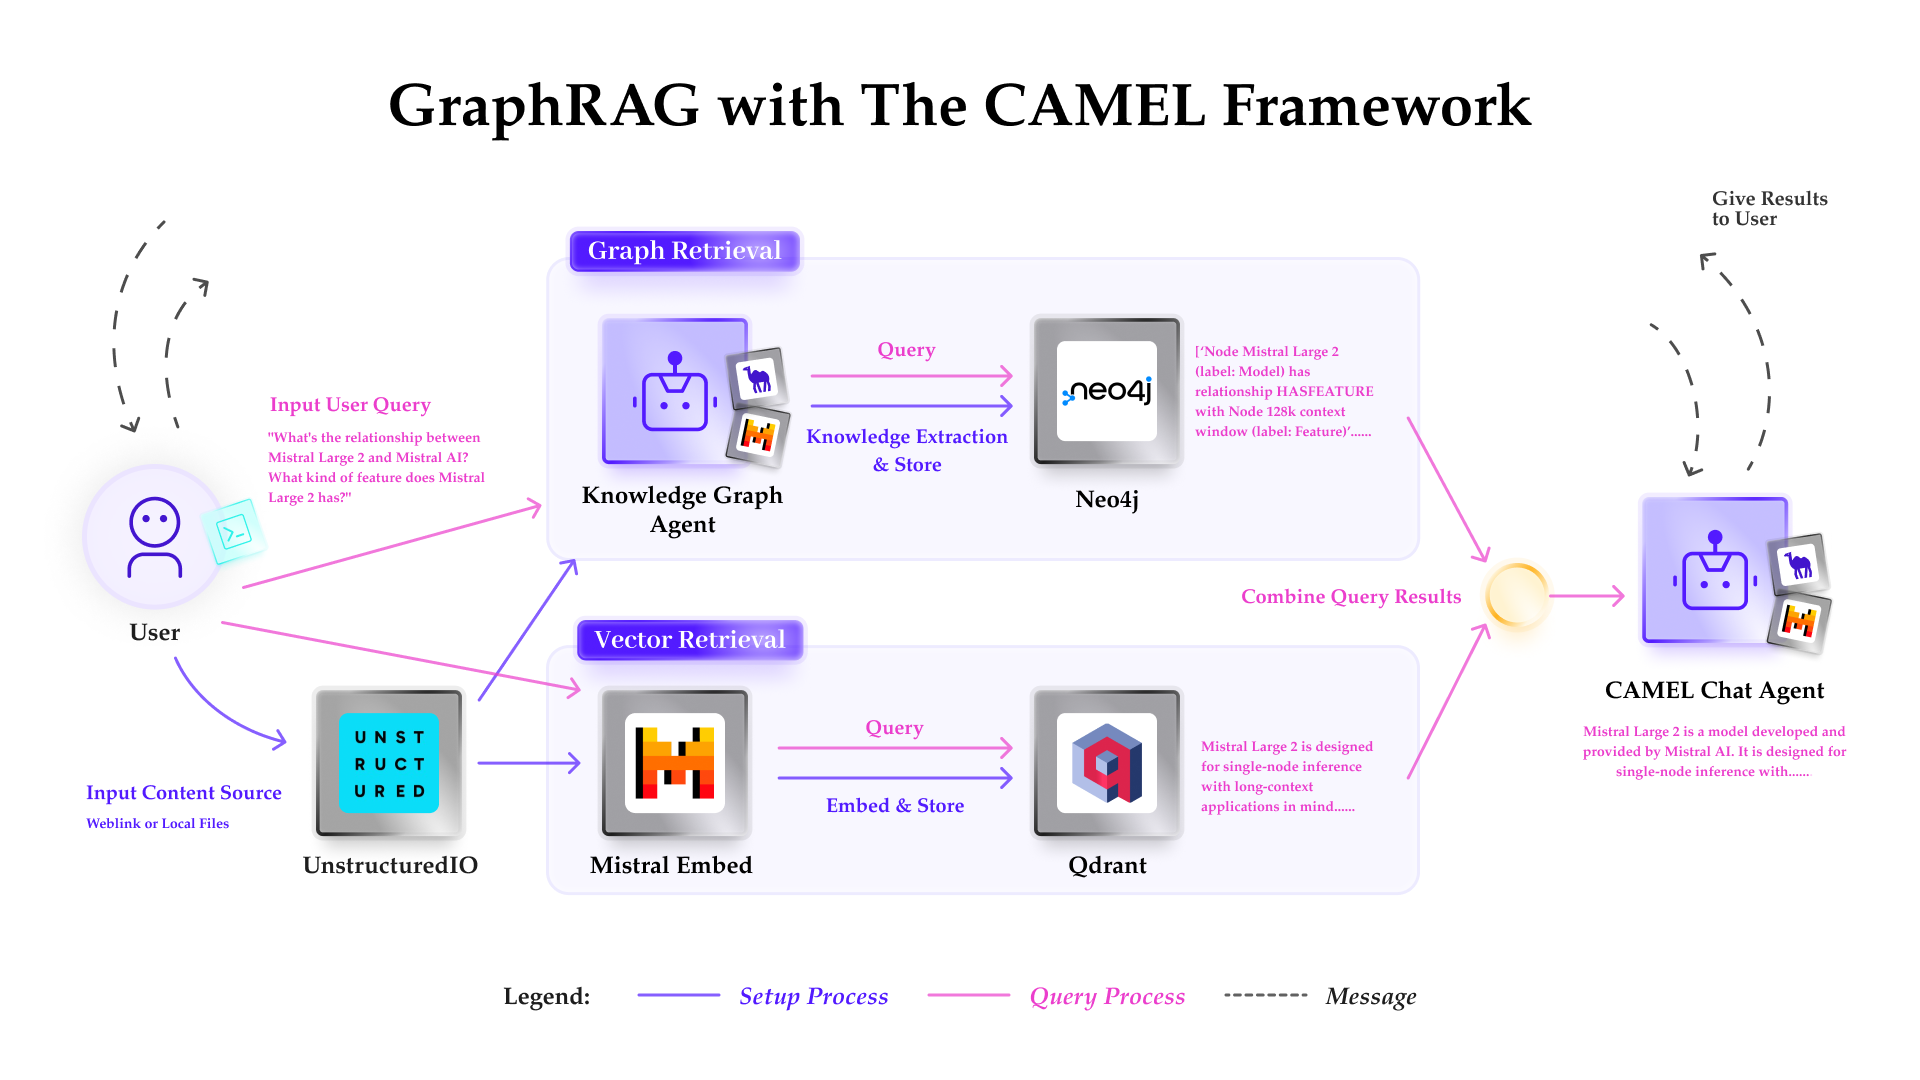

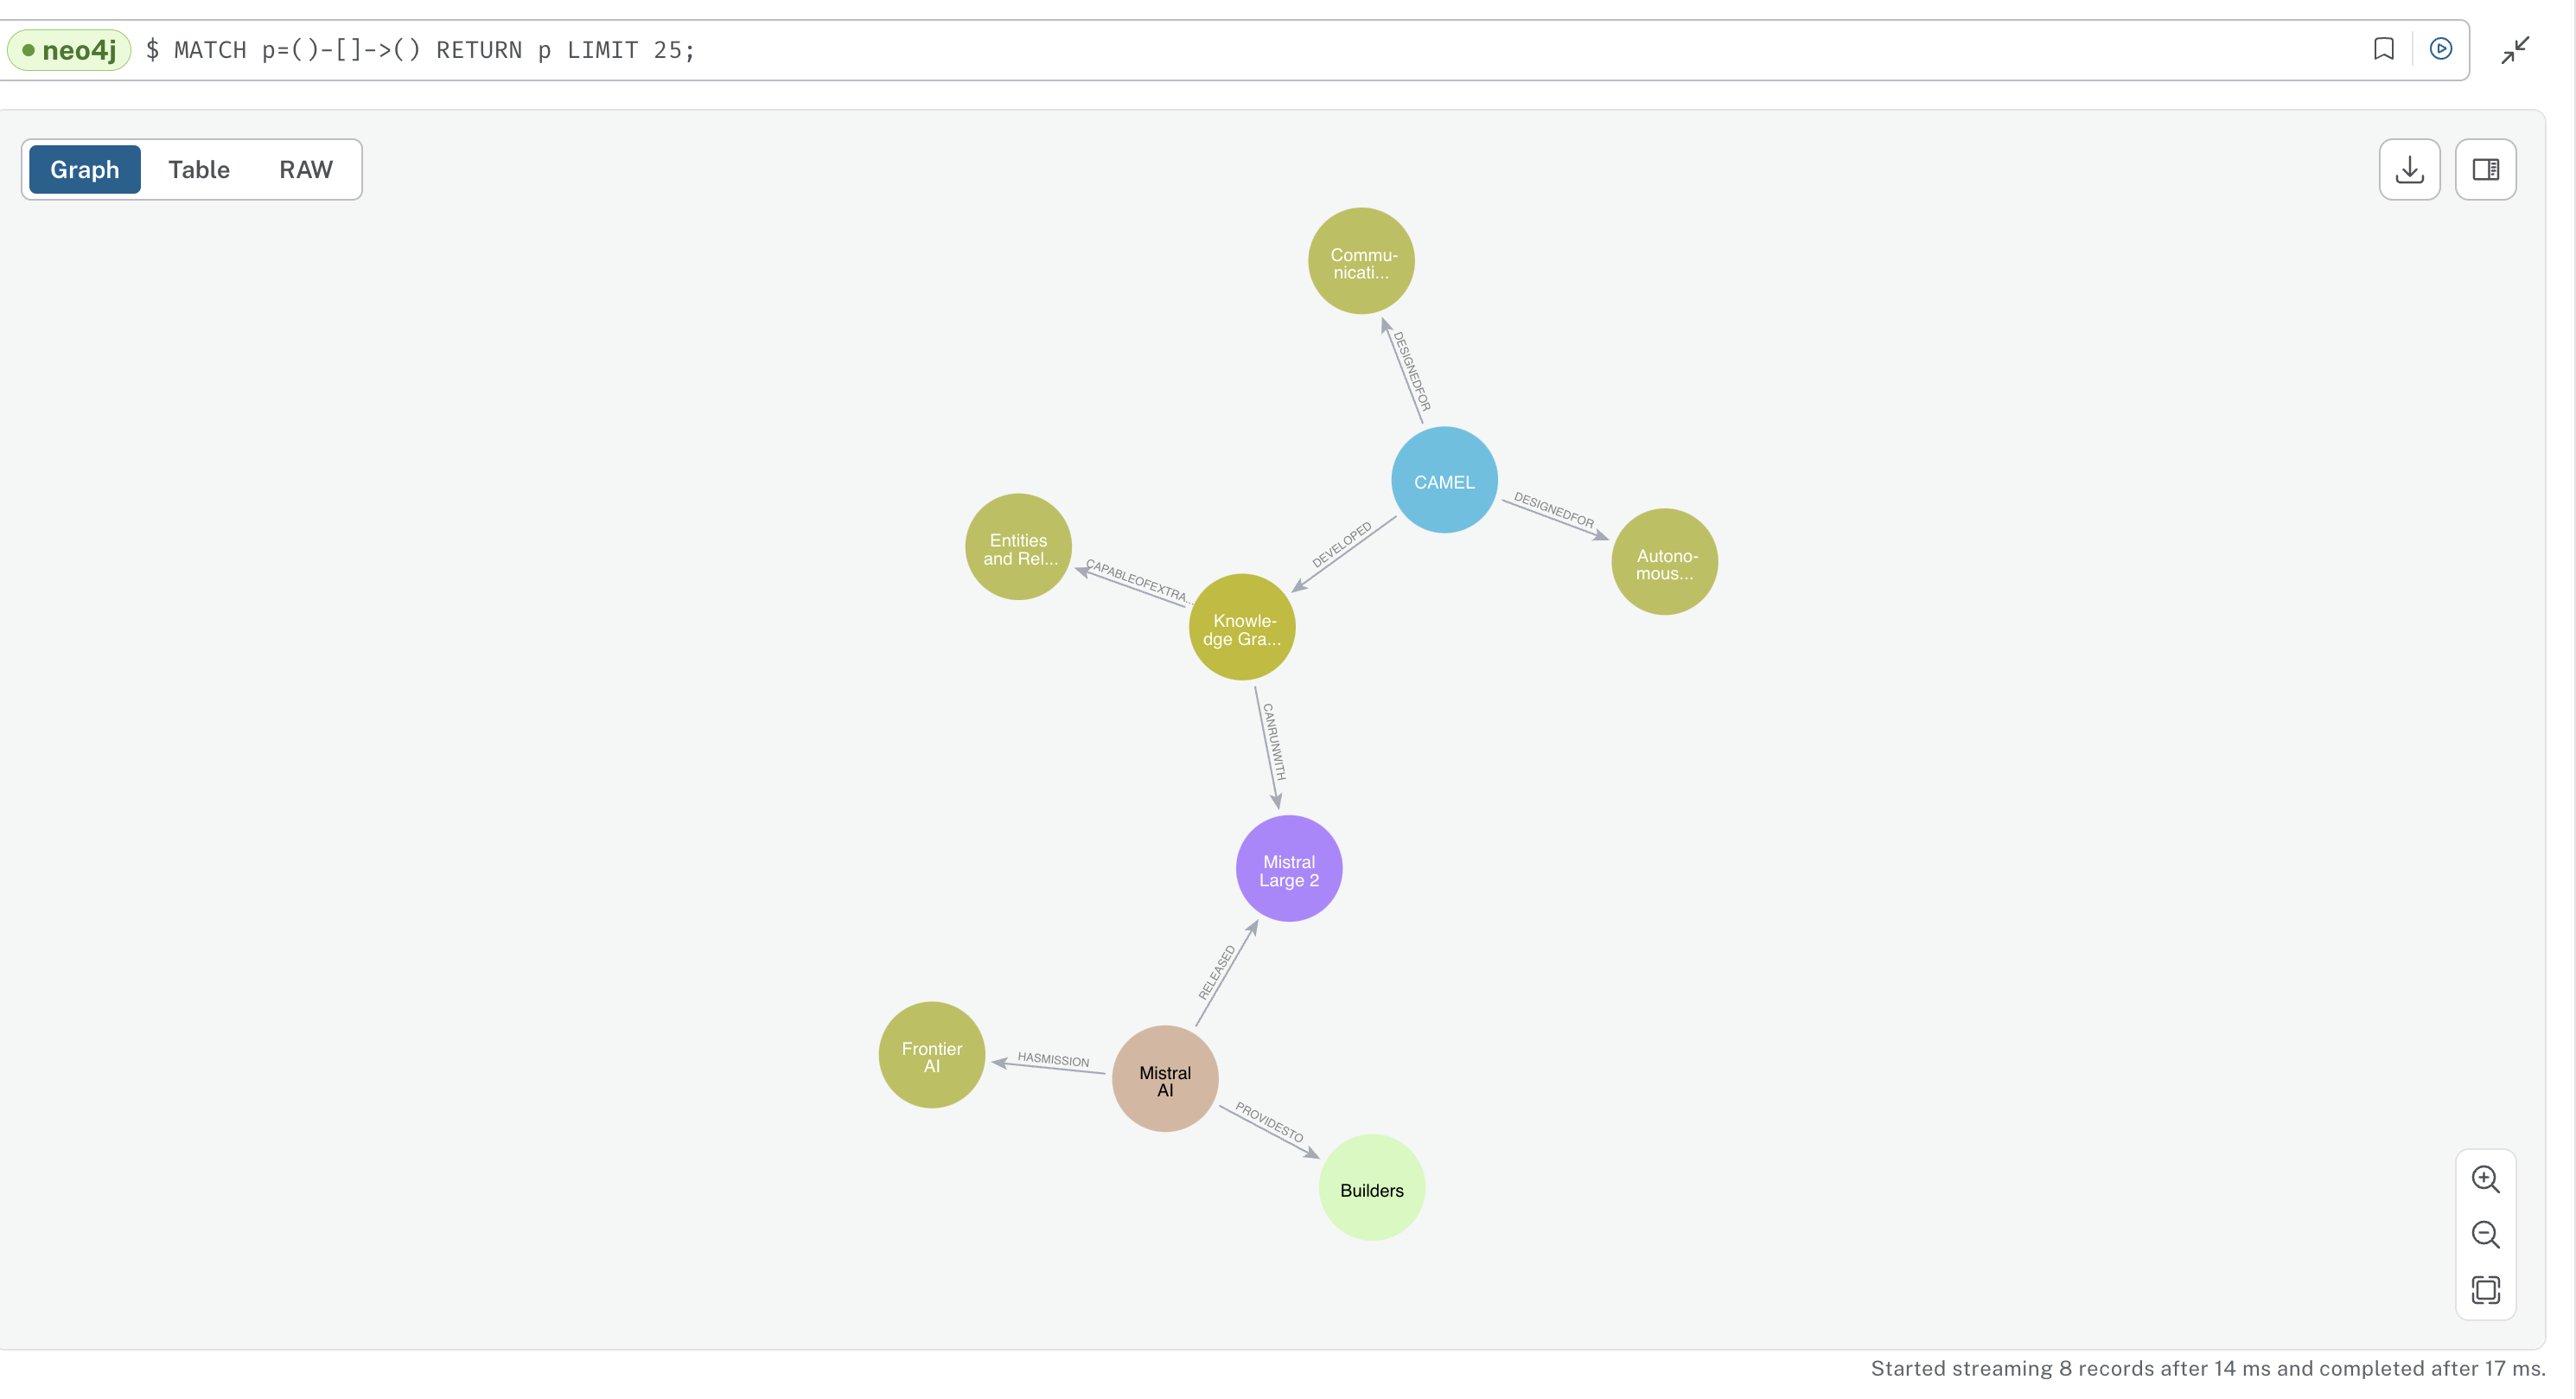

## 📦 Installation

First, install the CAMEL package with all its dependencies:

In [ ]:
%pip install "camel-ai[all]==0.2.1"

## 🔧 Setup

Import the required modules from CAMEL-AI:

In [2]:
from camel.models import ModelFactory
from camel.types import ModelPlatformType, ModelType
from camel.configs import MistralConfig, OllamaConfig
from camel.loaders import UnstructuredIO
from camel.storages import Neo4jGraph
from camel.retrievers import AutoRetriever
from camel.embeddings import MistralEmbedding
from camel.types import StorageType
from camel.agents import ChatAgent, KnowledgeGraphAgent
from camel.messages import BaseMessage

## 🔑 Setting Up API Keys


For secure access to Mistral AI's services, we'll prompt for the API key.

In [3]:
import os
from getpass import getpass

# Prompt for the API key securely
mistral_api_key = getpass('Enter your API key: ')
os.environ["MISTRAL_API_KEY"] = mistral_api_key

Enter your API key: ··········


## 🗄️ Configuring Neo4j Graph Database

Set up your Neo4j instance by providing the URL, username, and password, [here](https://neo4j.com/docs/aura/auradb/getting-started/create-database/) is the guidance, check your credentials in the downloaded .txt file. Note that you may need to wait up to 60 seconds if the instance has just been set up.

In [4]:
# Set Neo4j instance
n4j = Neo4jGraph(
    url="Your_URL",
    username="Your_Username",
    password="Your_Password",
)

## 🧠 Creating the Model

Set up Mistral Large 2 model using the CAMEL ModelFactory:

In [5]:
# Set up model
mistral_large_2 = ModelFactory.create(
    model_platform=ModelPlatformType.MISTRAL,
    model_type=ModelType.MISTRAL_LARGE,
    model_config_dict=MistralConfig(temperature=0.2).as_dict(),
)

In [6]:
# You can also set up model locally by using ollama
mistral_large_2_local = ModelFactory.create(
    model_platform=ModelPlatformType.OLLAMA,
    model_type="mistral-large",
    model_config_dict=OllamaConfig(temperature=0.2).as_dict(),
)

Failed to start Ollama server: [Errno 2] No such file or directory: 'ollama'.


## 🤖 Generate a Knowledge Graph Using CAMEL's Agent

Set up instances for knowledge graph agent:

In [7]:
# Set instance
uio = UnstructuredIO()
kg_agent = KnowledgeGraphAgent(model=mistral_large_2)

Provide an example text input that the knowledge graph agent will process:

In [8]:
# Set example text input
text_example = """
CAMEL has developed a knowledge graph agent can run with Mistral AI's most
advanced model, the Mistral Large 2. This knowledge graph agent is capable
of extracting entities and relationships from given content and create knowledge
graphs automaticlly.
"""

Create an element from the text and use the knowledge graph agent to extract node and relationship information:

In [9]:
# Create an element from given text
element_example = uio.create_element_from_text(
    text=text_example, element_id="0"
)

In [10]:
# Let Knowledge Graph Agent extract node and relationship information
ans_element = kg_agent.run(element_example, parse_graph_elements=False)
print(ans_element)

Sure, let's extract nodes and relationships from the given content. Here's the content for extraction:

Content:
"CAMEL has developed a knowledge graph agent that can run with Mistral AI's most advanced model, the Mistral Large 2. This knowledge graph agent is capable of extracting entities and relationships from given content and create knowledge graphs automatically."

### Extracted Nodes and Relationships

#### Nodes:

1. **CAMEL**
   - Type: Organization
2. **Knowledge Graph Agent**
   - Type: Software
3. **Mistral AI**
   - Type: Organization
4. **Mistral Large 2**
   - Type: Model
5. **Entities**
   - Type: Concept
6. **Relationships**
   - Type: Concept
7. **Content**
   - Type: Concept
8. **Knowledge Graphs**
   - Type: Concept

#### Relationships:

1. **CAMEL** developed **Knowledge Graph Agent**
   - Type: Developed
2. **Knowledge Graph Agent** can run with **Mistral Large 2**
   - Type: CanRunWith
3. **Mistral Large 2** is developed by **Mistral AI**
   - Type: DevelopedBy
4

In [11]:
# Check graph element
graph_elements = kg_agent.run(element_example, parse_graph_elements=True)
print(graph_elements)

nodes=[Node(id='CAMEL', type='Organization', properties={'source': 'agent_created'}), Node(id='knowledge graph agent', type='Software', properties={'source': 'agent_created'}), Node(id='Mistral AI', type='Organization', properties={'source': 'agent_created'}), Node(id='Mistral Large 2', type='Model', properties={'source': 'agent_created'}), Node(id='entities', type='Concept', properties={'source': 'agent_created'}), Node(id='relationships', type='Concept', properties={'source': 'agent_created'}), Node(id='content', type='Concept', properties={'source': 'agent_created'}), Node(id='knowledge graphs', type='Concept', properties={'source': 'agent_created'})] relationships=[Relationship(subj=Node(id='CAMEL', type='Organization', properties={'source': 'agent_created'}), obj=Node(id='knowledge graph agent', type='Software', properties={'source': 'agent_created'}), type='Developed', properties={'source': 'agent_created'}), Relationship(subj=Node(id='knowledge graph agent', type='Software', pro

Add the extracted graph elements to the Neo4j database:

In [12]:
# Add the element to neo4j database
n4j.add_graph_elements(graph_elements=[graph_elements])

### 🎉 Now you can go to [here](https://workspace-preview.neo4j.io/connection/connect) to check the knowledge graph built with CAMEL's Knowledge Graph Agent and Mistral AI's Mistral Large 2 model!

## 🗃️ Running Graph RAG with CAMEL

*Next we will showcase how to run RAG in a hybrid approach, combining vector retrieval and knowledge graph retrieval, to query and explore the stored knowledge.*

Set up a vector retriever with local storage and embedding model from Mistral AI:

In [13]:
# Set retriever
camel_retriever = AutoRetriever(
    vector_storage_local_path="local_data/embedding_storage",
    storage_type=StorageType.QDRANT,
    embedding_model=MistralEmbedding(),
)

Provide an example user query:

In [14]:
# Set one user query
query="what's the relationship between Mistral Large 2 and Mistral AI? What kind of feature does Mistral Large 2 has?"

Retrieve related content using the vector retriever, here we take Mistral AI's news in the website as example conetent, you can also set the local file path here:

In [16]:
# Get related content by using vector retriever
vector_result = camel_retriever.run_vector_retriever(
    query=query,
    contents="https://mistral.ai/news/mistral-large-2407/",
)

# Show the result from vector search
print(vector_result)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


{'Original Query': "what's the relationship between Mistral Large 2 and Mistral AI? What kind of feature does Mistral Large 2 has?", 'Retrieved Context': ['Mistral Large 2 is designed for single-node inference with long-context applications in mind – its size of 123 billion parameters allows it to run at large throughput on a single node.\nWe are releasing Mistral Large 2 under the Mistral Research License, that allows usage and modification for research and non-commercial usages. For commercial usage of Mistral Large 2 requiring self-deployment, a Mistral Commercial License must be acquired by contacting us.']}


Parse content from the specified URL and create knowledge graph data:

In [17]:
# Parse conetent from mistral website and create knowledge graph data by using
# the Knowledge Graph Agent, store the information into graph database.

elements = uio.parse_file_or_url(
    input_path="https://mistral.ai/news/mistral-large-2407/"
)
chunk_elements = uio.chunk_elements(
    chunk_type="chunk_by_title", elements=elements
)

graph_elements = []
for chunk in chunk_elements:
    graph_element = kg_agent.run(chunk, parse_graph_elements=True)
    n4j.add_graph_elements(graph_elements=[graph_element])
    graph_elements.append(graph_element)

Create an element from the user query:

In [18]:
# Create an element from user query
query_element = uio.create_element_from_text(
    text=query, element_id="1"
)

# Let Knowledge Graph Agent extract node and relationship information from the qyery
ans_element = kg_agent.run(query_element, parse_graph_elements=True)

Match entities from the query in the knowledge graph storage content:

In [19]:
# Match the enetity got from query in the knowledge graph storage content
kg_result = []
for node in ans_element.nodes:
    n4j_query = f"""
MATCH (n {{id: '{node.id}'}})-[r]->(m)
RETURN 'Node ' + n.id + ' (label: ' + labels(n)[0] + ') has relationship ' + type(r) + ' with Node ' + m.id + ' (label: ' + labels(m)[0] + ')' AS Description
UNION
MATCH (n)<-[r]-(m {{id: '{node.id}'}})
RETURN 'Node ' + m.id + ' (label: ' + labels(m)[0] + ') has relationship ' + type(r) + ' with Node ' + n.id + ' (label: ' + labels(n)[0] + ')' AS Description
"""
    result = n4j.query(query=n4j_query)
    kg_result.extend(result)

kg_result = [item['Description'] for item in kg_result]

# Show the result from knowledge graph database
print(kg_result)

['Node Mistral Large 2 (label: Model) has relationship HASFEATURE with Node 128k context window (label: Feature)', 'Node Mistral Large 2 (label: Model) has relationship SUPPORTSLANGUAGE with Node French (label: Language)', 'Node Mistral Large 2 (label: Model) has relationship SUPPORTSLANGUAGE with Node German (label: Language)', 'Node Mistral Large 2 (label: Model) has relationship SUPPORTSLANGUAGE with Node Spanish (label: Language)', 'Node Mistral Large 2 (label: Model) has relationship SUPPORTSLANGUAGE with Node Italian (label: Language)', 'Node Mistral Large 2 (label: Model) has relationship SUPPORTSLANGUAGE with Node Portuguese (label: Language)', 'Node Mistral Large 2 (label: Model) has relationship SUPPORTSLANGUAGE with Node Arabic (label: Language)', 'Node Mistral Large 2 (label: Model) has relationship SUPPORTSLANGUAGE with Node Hindi (label: Language)', 'Node Mistral Large 2 (label: Model) has relationship SUPPORTSLANGUAGE with Node Russian (label: Language)', 'Node Mistral L

Combine results from the vector search and knowledge graph entity search:

In [23]:
# combine result from vector seach and knowledge graph entity search
comined_results = str(vector_result) + "\n".join(kg_result)

Set up an assistant agent to answer questions based on the retrieved context:

In [24]:
# Set agent
sys_msg = BaseMessage.make_assistant_message(
    role_name="CAMEL Agent",
    content="""You are a helpful assistant to answer question,
        I will give you the Original Query and Retrieved Context,
    answer the Original Query based on the Retrieved Context.""",
)

camel_agent = ChatAgent(system_message=sys_msg,
                        model=mistral_large_2)

# Pass the retrieved infomation to agent
user_prompt=f"""
The Original Query is {query}
The Retrieved Context is {comined_results}
"""

user_msg = BaseMessage.make_user_message(
    role_name="CAMEL User", content=user_prompt
)

# Get response
agent_response = camel_agent.step(user_msg)

print(agent_response.msg.content)

### Relationship Between Mistral Large 2 and Mistral AI

Mistral Large 2 is a model developed by Mistral AI. The relationship between Mistral Large 2 and Mistral AI is that Mistral AI has created and provides the Mistral Large 2 model.

### Features of Mistral Large 2

Mistral Large 2 has several notable features and capabilities:

1. **Size and Performance**:
   - **123 Billion Parameters**: This size allows it to run at large throughput on a single node.
   - **128k Context Window**: This feature enables the model to handle long-context applications effectively.

2. **Language Support**:
   - Mistral Large 2 supports multiple languages, including French, German, Spanish, Italian, Portuguese, Arabic, Hindi, Russian, Chinese, Japanese, and Korean.

3. **Coding Language Support**:
   - The model supports various coding languages such as Python, Java, C, C++, JavaScript, and Bash.

4. **Design and Usage**:
   - **Single-Node Inference**: Designed for single-node inference, making it effi

## 🌟 Highlights

*   Automated Knowledge Extraction: The Knowledge Graph Agent automates the extraction of entities and relationships, making the process efficient and effective.

*   Mistral AI Integration: This cookbook showcases the integration of Mistral AI's advanced models, particularly the Mistral Large 2, with CAMEL-AI to create a powerful knowledge graph system.


*   Secure and Scalable: Using CAMEL-AI's robust architecture and Neo4j for graph storage ensures that the solution is both secure and scalable.

By following this cookbook, you can leverage the cutting-edge capabilities of **CAMEL AI** and **Mistral AI** to build sophisticated knowledge graphs, facilitating advanced data analysis and retrieval tasks.